# Data Processing

| Property               | observations and model                   | 
|------------------------|------------------------------------------|
| **Content**            | `sst`                                    |
| **Resolution**         | `1.0°`                                   |
| **Mask**               | `Yes (NaN)`                              | 
| **Time**               | `2011-01 to 2022-12 (monthly)`           |
| **Dimensions**         | `time`, `lat`, `lon`                     |
| **Dimension lon/lat**  | `1D`                                     |
| **Name time**          | `time`                                   |
| **Longitude range**    | `0.50° to 359.50° (west to east) `       |
| **Latitude range**     | `89.50° to -89.50°` (north to south)     |

## Imports

In [1]:
import xarray as xr
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regionmask
import contextlib, os, sys
import cartopy.crs as ccrs
from data_utils import show_coverage_mask_model, fill_coastal_points_in_time

## Processing

In [2]:
observations = xr.open_dataset('../data/observations/sst.mnmean.nc')
model = xr.open_dataset('../data/model/nemo00_1m_201001_202212_grid_T.nc')
mesh = xr.open_dataset('../data/model/orca05l75_domain_cfg_nemov5_10m.nc')

### Extracting SST

In [3]:
model = model['tos']
observations = observations['sst']

### Renaming

In [4]:
model = model.rename({
    'nav_lon': 'lon',
    'nav_lat': 'lat',
    'time_counter': 'time'
})

times = model.time.values.astype('datetime64[M]')  # truncate to month start
model['time'] = times
model = model.assign_coords(lon=mesh['glamt'], lat=mesh['gphit'])

### 2011 to 2022

In [5]:
observations = observations.sel(time=slice("2011-01", "2022-12"))
model = model.sel(time=slice("2011-01", "2022-12"))

### Filling coastal points

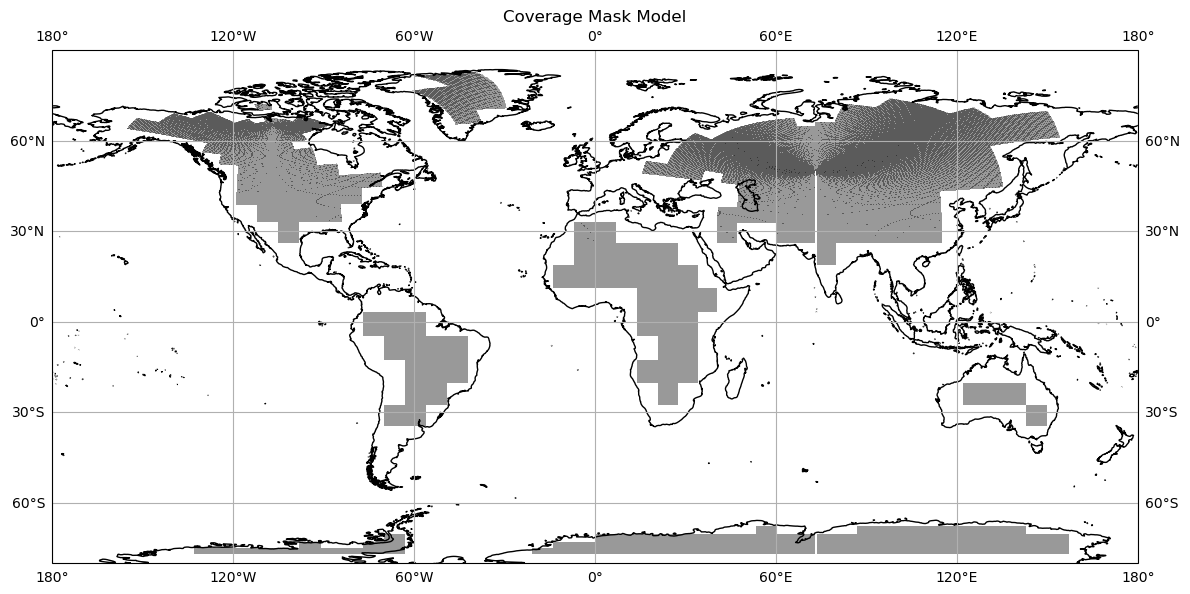

In [6]:
show_coverage_mask_model(model, mesh)

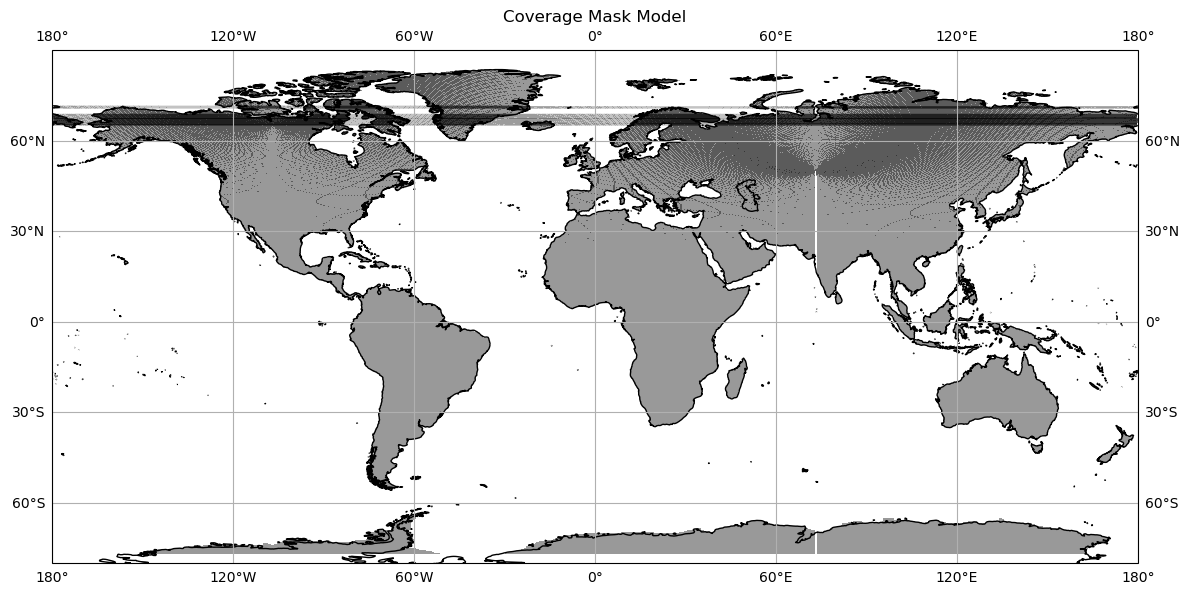

In [7]:
land_mask = mesh['bathy_metry'] == 0
model = model.where(~land_mask)
show_coverage_mask_model(model, mesh)

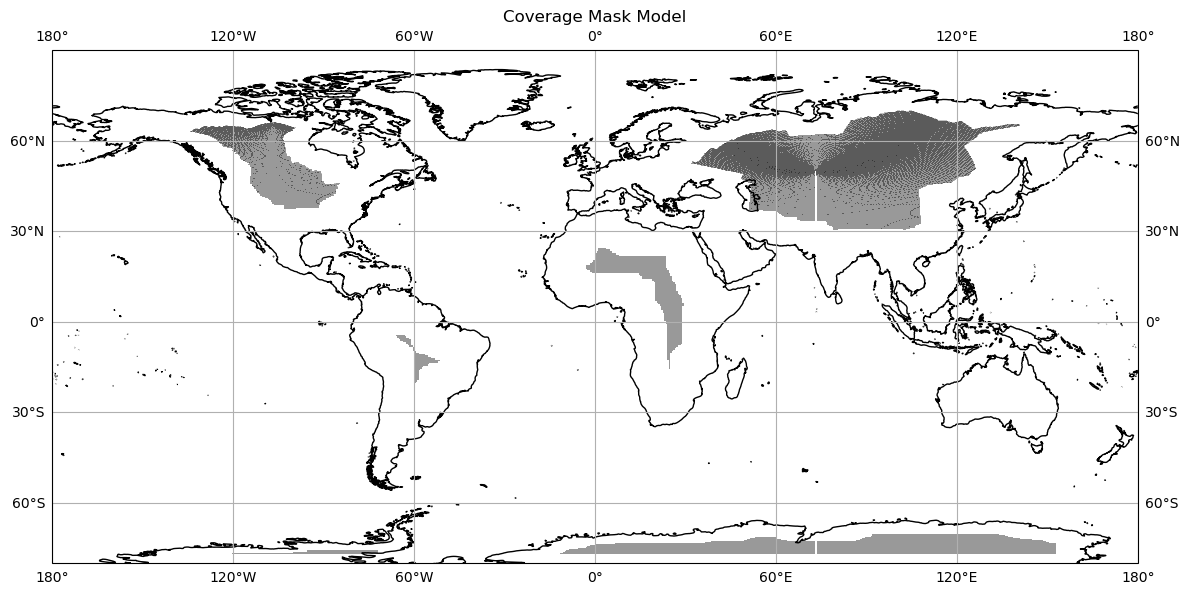

In [8]:
filled_model = fill_coastal_points_in_time(model, 20)
show_coverage_mask_model(filled_model, mesh)

In [9]:
filled_model

<xarray.DataArray 'tos' (time: 144, y: 510, x: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) datetime64[ns] 2011-01-01 2011-02-01 ... 2022-12-01
Dimensions without coordinates: y, x
Attributes:
    standard_name:       bulk_sea_surface_temperature
    long_name:           sea_surface_temperature
    units:               degC
    cell_methods:        time: mean (interval: 2400 s) time_counter: mean
    online_operation:    average
    interval_operation:  2400 s
    interval_write:      1 d

### Regridding (interpolation): Model -> Observations

In [10]:
import xesmf as xe

target_grid = xr.Dataset({
    'lon': (['lon'], np.arange(-179.5, 179.5 + 1)),  
    'lat': (['lat'], np.arange(-89.5, 89.5 + 1))     
})

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    regridder = xe.Regridder(
        filled_model, target_grid,
        method='bilinear',
        filename='weights_bilinear.nc',  
        reuse_weights=True,                  
        ignore_degenerate=True,
        periodic=True
    )

model_regridded = regridder(filled_model)

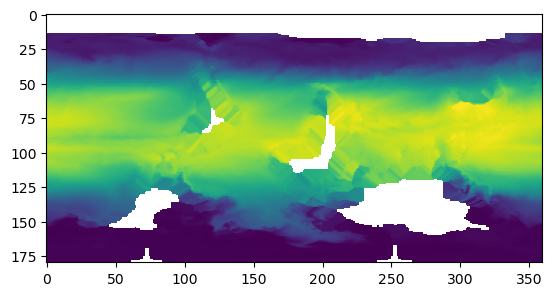

In [11]:
plt.imshow(model_regridded.isel(time=0))

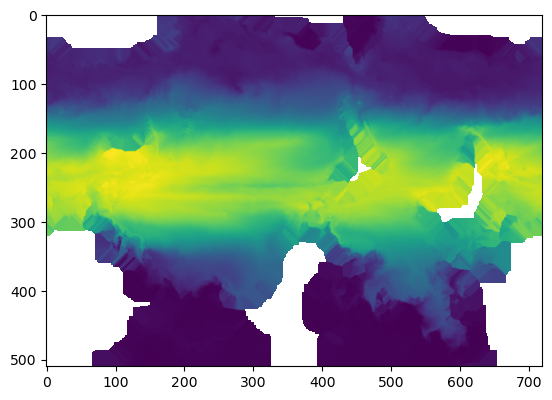

In [12]:
plt.imshow(filled_model.isel(time=0))

### -180 to 180 -> 0 to 360 *and* -89.5 to 89.5 -> 89.5 to -89.5 *and* dimension ordering

In [13]:
model_regridded['lon'] = (model_regridded['lon'] + 360) % 360
model_regridded = model_regridded.sortby('lon') 
model_regridded = model_regridded.sortby('lat', ascending=False)
model_regridded = model_regridded.transpose('time', 'lat', 'lon')
observations = observations.transpose('time', 'lat', 'lon')

### Masking the continents

In [14]:
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(observations)
ocean_mask = land_mask.isnull()
observations = observations.where(ocean_mask)  
model_regridded = model_regridded.where(ocean_mask) 

### Naming coordinates and attributes

In [15]:
model_regridded.coords['lon'].attrs.update({
    'long_name': 'Longitude',
    'units': 'degrees_east',
    'standard_name': 'longitude'
})

model_regridded.coords['lat'].attrs.update({
    'long_name': 'Latitude',
    'units': 'degrees_north',
    'standard_name': 'latitude'
})

model_regridded.attrs.update({
    'long_name': 'Monthly Mean of Sea Surface Temperature',
    'units': 'degC',
    'standard_name': 'sea_surface_temperature'
})

### Plotting

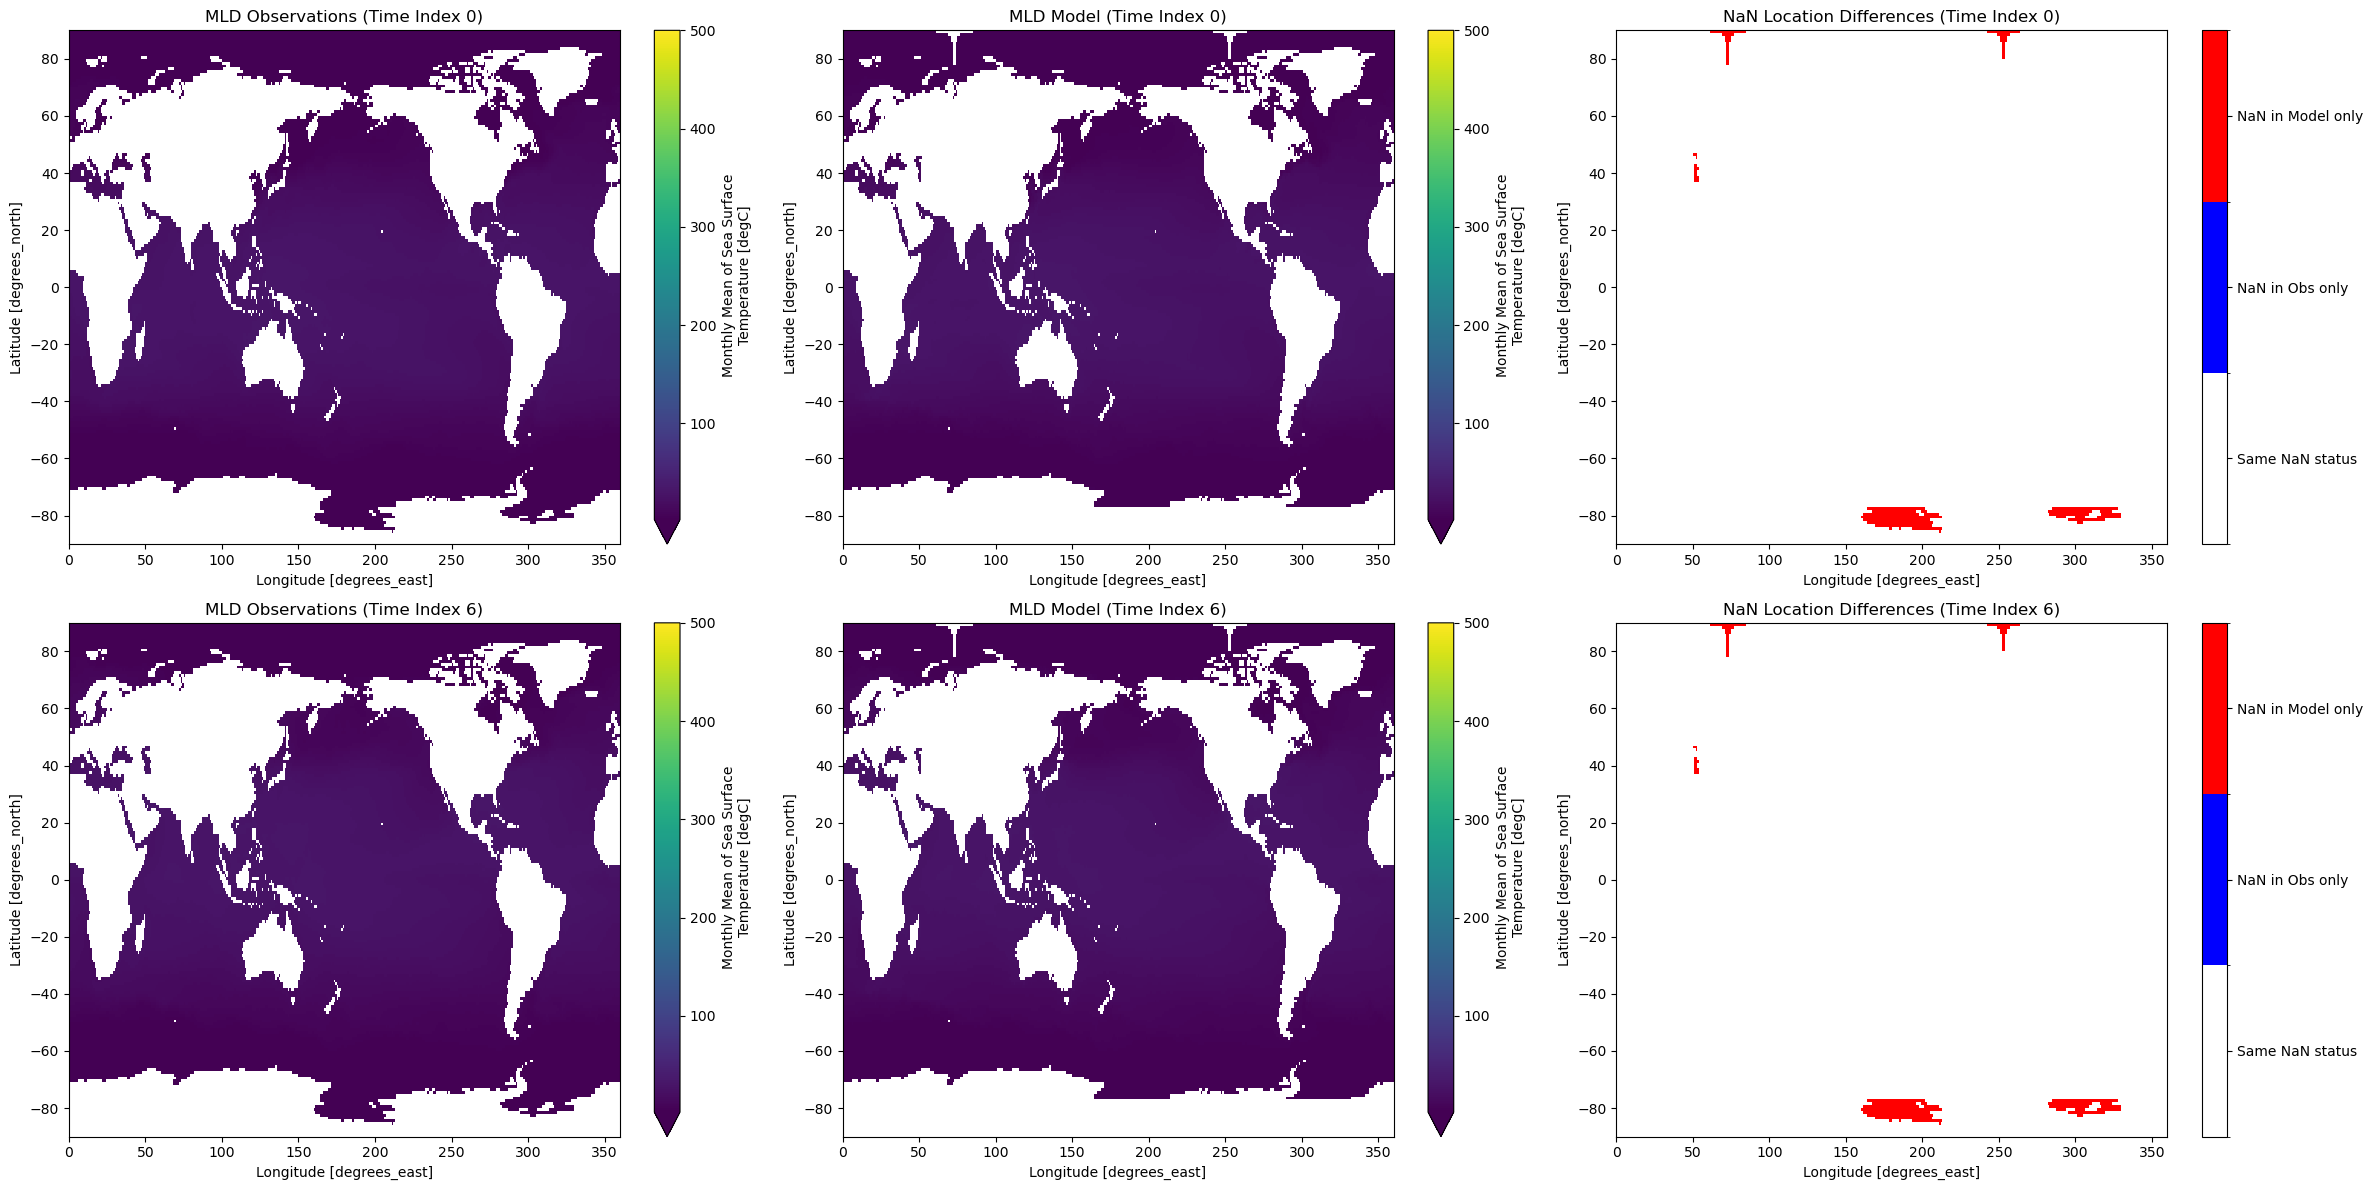

In [16]:
time_indices = [0, 6]  

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

# Custom colormap and normalization
cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for i, time_index in enumerate(time_indices):
    # Extract slices
    obs_slice = observations.isel(time=time_index)
    model_slice = model_regridded.isel(time=time_index)

    # Plot fields
    obs_slice.plot(ax=axes[i, 0], vmin=2, vmax=500)
    axes[i, 0].set_title(f'MLD Observations (Time Index {time_index})')

    model_slice.plot(ax=axes[i, 1], vmin=2, vmax=500)
    axes[i, 1].set_title(f'MLD Model (Time Index {time_index})')

    # NaN masks
    obs_nan = obs_slice.isnull()
    model_nan = model_slice.isnull()

    # NaN difference classification
    nan_diff = xr.full_like(obs_nan, 0, dtype=int)
    nan_diff = nan_diff.where(obs_nan == model_nan, 1)
    nan_diff = nan_diff.where(~((~obs_nan) & model_nan), 2)
    nan_diff = nan_diff.where(obs_nan == model_nan, nan_diff)

    # Plot NaN differences
    im = nan_diff.plot(ax=axes[i, 2], cmap=cmap, norm=norm, add_colorbar=False)
    cbar = plt.colorbar(im, ax=axes[i, 2], ticks=[0, 1, 2])
    cbar.ax.set_yticklabels([
        'Same NaN status',
        'NaN in Obs only',
        'NaN in Model only'
    ])
    axes[i, 2].set_title(f'NaN Location Differences (Time Index {time_index})')

plt.tight_layout()


### Saving in a file

In [17]:
model_regridded.to_netcdf('../data/processed/nemo00_sst_monthly_2011_2022.nc', mode='w')
observations.to_netcdf('../data/processed/observations_sst_monthly_2011_2022.nc', mode='w')